In [2]:
import os
from gerrychain import Graph, GeographicPartition, Partition, Election, accept, updaters
from gerrychain.updaters import Tally, cut_edges
import geopandas as gpd
import numpy as np
from gerrychain.random import random
import copy
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip, recom
from gerrychain.accept import always_accept
from gerrychain.metrics import polsby_popper
from gerrychain import constraints
from gerrychain.constraints import no_vanishing_districts
from collections import defaultdict, Counter
from itertools import combinations_with_replacement
import matplotlib.pyplot as plt
import networkx as nx
import pandas
import math
from functools import partial


In [8]:
graph = Graph.from_json("./VA_Block_Groups_33.json")
print("made graph")

made graph
{'boundary_node': False, 'area': 1.130699073262681e-07, 'OBJECTID': 253871, 'COUNTYFP10': '710', 'TRACTCE10': '003501', 'BLOCKCE10': '3043', 'GEOID10': '517100035013043', 'TAPERSONS': 0, 'TAHISPANIC': 0, 'VAPERSONS': 0, 'VAHISPANIC': 0, 'WHITE': 0, 'BLACK': 0, 'AIAN': 0, 'ASIAN': 0, 'HAWPI': 0, 'OTHER': 0, 'MULTI': 0, 'VAPWHITE': 0, 'VAPBLACK': 0, 'VAPAIAN': 0, 'VAPASIAN': 0, 'VAPHAWPI': 0, 'VAPOTHER': 0, 'VAPMULTI': 0, 'HSPWHITE': 0, 'HSPBLACK': 0, 'HSPOTHER': 0, 'VAPHISPWH': 0, 'VAPHISPBL': 0, 'VAPHISPOT': 0, 'REGVOTERS': 0, 'D_LTGOV': 0.0, 'R_LTGOV': 0.0, 'D_GOV': 0.0, 'R_GOV': 0.0, 'D_ATTGEN': 0.0, 'R_ATTGEN': 0.0, 'VTD_ID_1': '710414', 'LOCALITY': 'Norfolk', 'Name10': '710414 - Young Park', 'Shape_Leng': 0.00136064784, 'Shape_Area': 1.1307e-07, 'ABName': '710414 - Young Park', 'HB5005': '89', 'REMEDIAL': '89', 'Pfield_2': '77'}


In [17]:
my_updaters = {
    "population": updaters.Tally("TAPERSONS", alias="population"),
    "BVAP": updaters.Tally("VAPBLACK", alias="BVAP"),
    "VAP": updaters.Tally("VAPERSONS", alias="VAP")
}
initial_partition = GeographicPartition(graph, assignment="REMEDIAL", updaters=my_updaters)
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
proposal = partial(recom,
                   pop_col="TAPERSONS",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [31]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=20
)

In [32]:
data = pandas.DataFrame()
for partition in chain:
    print(".", end="")
    data.append([x/y for x, y in zip(list(partition["BVAP"].values()), list(partition["VAP"].values()))])
#data = pandas.DataFrame(
#    sorted([x/y for x, y in zip(list(partition["BVAP"].values()), list(partition["VAP"].values()))])
#    for partition in chain
#)

....................

ValueError: List of boxplot statistics and `positions` values must have same the length

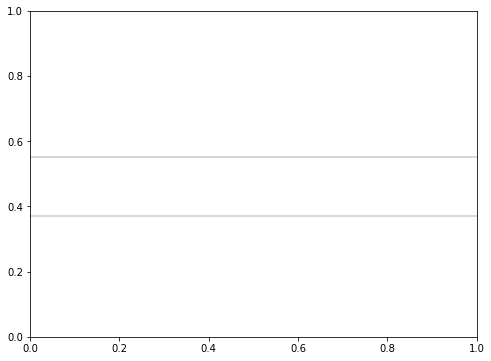

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw lines
ax.axhline(0.55, color="#cccccc")
ax.axhline(0.37, color="#cccccc")


# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))


# Annotate
ax.set_title("Ensemble BVAP for VA")
ax.set_ylabel("BVAP %")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()